In [1]:
from nine_mens_morris import nmm

In [2]:
env = nmm.env(render_mode='ansi')

In [3]:
env.reset()
print(env.possible_agents)
print(env.action_spaces['player_0'], env.observation_spaces['player_0'])
obs = env.observe('player_0')
obs['observation'].shape, obs['action_mask']

['player_0', 'player_1']
Discrete(24) Box(0.0, 1.0, (72,), float32)


((72,),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1]))

In [4]:
from IPython.display import clear_output
from collections import deque
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchmetrics import MeanMetric
from tqdm import tqdm
from torch.nn.functional import one_hot

# Neural Network

In [19]:
class AlphaZeroNMM(nn.Module):
    def __init__(self):
        super().__init__()
        # 76 = (24 pieces of current player) + (24 pieces of opponent) + (position of the lifted piece to move) + (4 action types: place_phase_1, lift_phase_2, drop_phase_2, kill)
        self.v = nn.Sequential(
            nn.Linear(76, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Tanh(),
        )

        self.p_place = nn.Sequential(
            nn.Linear(76, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 24),
        )

        self.p_lift = nn.Sequential(
            nn.Linear(76, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 24),
        )

        self.p_drop = nn.Sequential(
            nn.Linear(76, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 24),
        )

        self.p_kill = nn.Sequential(
            nn.Linear(76, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 24),
        )

    def forward(self, s, action_types):
        # Add action types to observation because the value network should know which phase you're in to make it fully observable.
        action_type_one_hot = one_hot(torch.tensor(action_types), num_classes=4)  # (b, 4)
        s = torch.cat((s, action_type_one_hot), dim=1)

        v = self.v(s)  # (b, 1)
        p_place = self.p_place(s)  # (b, 24)
        p_lift = self.p_lift(s)  # (b, 24)
        p_drop = self.p_drop(s)  # (b, 24)
        p_kill = self.p_kill(s)  # (b, 24)

        p = []
        for i in range(len(s)):
            if action_types[i] == nmm.ActionType.PLACE:
                p.append(p_place[i])
            elif action_types[i] == nmm.ActionType.LIFT:
                p.append(p_lift[i])
            elif action_types[i] == nmm.ActionType.DROP:
                p.append(p_drop[i])
            elif action_types[i] == nmm.ActionType.KILL:
                p.append(p_kill[i])
            else:
                raise Exception(f'Action type must be 0, 1, 2 or 3.')
        p = torch.stack(p)  # (b, 24)
        p = torch.softmax(p, dim=1)

        return p, v

# MCTS

Similar to AlphaZero's MCTS, but with following changes:

1. Agents do not necessarily switch turns at every level.
2. Limited number of visits for each node in case of cyclic state graph (loops).
    https://github.com/jonathan-laurent/AlphaZero.jl/issues/47

In [6]:
class MCTS:
    def __init__(self, model):
        self.model = model
        self.q_sa = {}  # stores Q values for (s, a)
        self.n_sa = {}  # stores # of times edge (s, a) was visited
        self.p_s = {}  # stores initial policy returned by neural net

    def simulate(self, env):
        s = env.state()
        obs = env.observe(env.agent_selection)
        action_mask = obs['action_mask']
        action_type = obs['action_type']
        obs = obs['observation']

        """ EVALUATE """
        # If s is leaf (different from terminal state), then evaluate s with model
        if s not in self.p_s:
            p, v = self.evaluate(obs, action_mask, action_type)
            self.p_s[s] = p
            return v  # This is NOT -v because sign doesn't necessarily change at every level.

        """ SELECT """
        cpuct = 1
        q = np.array([self.q_sa.get((s, a), 0) for a in range(len(action_mask))])
        n = np.array([self.n_sa.get((s, a), 0) for a in range(len(action_mask))])

        # (1− ε)pa+ εηa, where η∼ Dir(0.03) and ε= 0.25
        p = 0.75 * self.p_s[s] + 0.25 * np.random.dirichlet([2] * len(q))

        u = q + cpuct * p * np.sqrt(n.sum() + 1e-6) / (1 + n)
        u[action_mask == 0] = -np.inf
        a = u.argmax()

        """ EXPAND """
        next_env = deepcopy(env)
        next_env.step(a)
        agent, next_agent = env.agent_selection, next_env.agent_selection
        # If terminal state, v = z
        if next_env.terminations[agent] or next_env.truncations[next_agent]:
            v = next_env.rewards[agent]
        else:
            v = self.simulate(next_env)
            if agent != next_agent:
                v = -v  # Change sign only if next agent is opponent.

        """ BACKTRACK """
        if (s, a) in self.q_sa:
            # Recompute the average
            sum_ = self.n_sa[(s, a)] * self.q_sa[(s, a)] + v
            self.n_sa[(s, a)] += 1
            self.q_sa[(s, a)] = sum_ / self.n_sa[(s, a)]
        else:
            self.q_sa[(s, a)] = v
            self.n_sa[(s, a)] = 1
        return v  # Again, this is NOT -v.

    def evaluate(self, obs, action_mask, action_type):
        obs = torch.from_numpy(obs).float().view(1, -1)  # (1, 48)

        # Get predictions
        self.model.eval()
        with torch.no_grad():
            p, v = self.model(obs, [action_type])  # (1, 24), (1, 1)
        p = p.cpu().numpy()[0]  # (24,)
        v = v.cpu().numpy()[0][0]  # scalar

        # Legal action masking.
        p *= action_mask

        # Normalizing probabilities
        p_sum = p.sum()
        if p_sum > 0:
            p /= p_sum  # re-normalize
        else:
            print("All valid moves are masked, doing a workaround.")
            p = action_mask / action_mask.sum()

        return p, v

    def get_action_prob(self, env, temperature=1):
        s = env.state()
        p = [self.n_sa.get((s, a), 0) for a in range(len(self.p_s[s]))]
        p = np.array(p, dtype=np.float32) ** 1 / temperature
        p *= env.action_masks[env.agent_selection]
        return p / p.sum()

# Helper functions

In [7]:
def plot(iteration, losses, win_rates, lose_rates):
    clear_output(True)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.set_title(f"Loss. Iteration: {iteration}")
    ax1.plot(losses)
    ax2.set_title(f'Win rate and lose rate')
    ax2.plot(win_rates, label='Win Rate')
    ax2.plot(lose_rates, label='Lose Rate')
    ax2.legend()
    plt.show()


def evaluate(env, model1, model2, n_episodes):
    wins1, wins2 = 0, 0
    for _ in tqdm(range(n_episodes), desc='Evaluating'):
        env.reset()
        mcts_ = MCTS(model1), MCTS(model2)
        step = 0
        while not (env.terminations[env.agent_selection] or env.truncations[env.agent_selection]):
            step += 1
            mcts = mcts_[int(step % 2 == 0)]

            [mcts.simulate(env) for _ in range(10)]
            p = mcts.get_action_prob(env)
            action = np.random.choice(len(p), p=p)

            env.step(action)
        r = env.rewards[env.agents[0]]
        wins1 += int(r > 1)
        wins2 += int(r < 1)
    return wins1 / n_episodes, wins2 / n_episodes


def self_play(env, mcts: MCTS):
    tuples = []
    env.reset()
    while not (env.terminations[env.agent_selection] or env.truncations[env.agent_selection]):
        [mcts.simulate(env) for _ in range(25)]
        p = mcts.get_action_prob(env)
        action = np.random.choice(len(p), p=p)
        obs = env.observe(env.agent_selection)
        tuples.append([obs['observation'], obs['action_type'], p, env.agent_selection])

        env.step(action)
    for tup in tuples:
        tup[-1] = env.rewards[tup[-1]]
    return tuples

# Initialization

In [20]:
env = nmm.env()

device = 'cpu'
model = AlphaZeroNMM().to(device)
old_model = deepcopy(model)
optimizer = Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)

losses = []
win_rates = []
lose_rates = []
dataset = deque([], maxlen=25000)

# Training

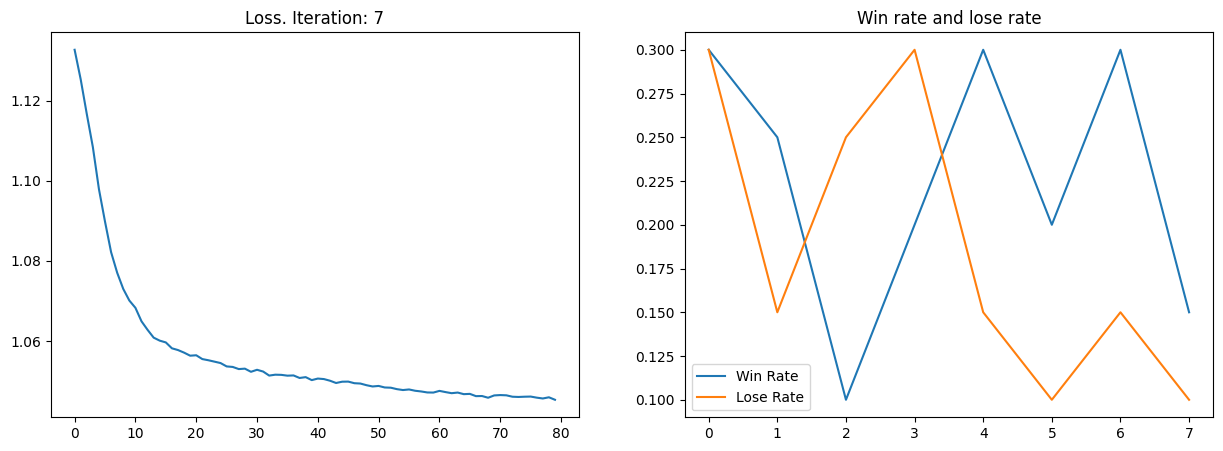

Self-Play:  32%|███▏      | 8/25 [00:22<01:00,  3.59s/it]

In [ ]:
for iteration in range(50):
    """ Self Play """
    for _ in tqdm(range(25), desc='Self-Play'):
        mcts = MCTS(model)
        dataset += self_play(env, mcts)

    """ Train """
    model.train()
    for epoch in tqdm(range(10), desc='Training'):
        loss_mean = MeanMetric()
        for state, action_type, p, v in DataLoader(dataset, batch_size=16, shuffle=True):
            p_pred, v_pred = model(state.float().to(device), action_type)
            loss = (v.to(device) - v_pred).pow(2).mean() - (p.to(device) * p_pred.log()).mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_mean(loss.item())
        losses.append(loss_mean.compute())

    """ Evaluate """
    wins_0, loses_0 = evaluate(env, model, old_model, 10)
    loses_1, wins_1 = evaluate(env, old_model, model, 10)

    win_rates.append((wins_0 + wins_1) / 2)
    lose_rates.append((loses_0 + loses_1) / 2)

    if win_rates[-1] > lose_rates[-1]:
        old_model = deepcopy(model)

    plot(iteration, losses, win_rates, lose_rates)

In [ ]:
torch.save(model.state_dict(), '/Users/akhildevarashetti/code/reward_lab/exp/nmm/weights/model_2.pth')

In [ ]:
model

# Sample Gameplay

In [ ]:
env.reset()
mcts = MCTS(model)

In [ ]:
[mcts.simulate(env) for _ in range(25)]
p = mcts.get_action_prob(env)
# action = np.random.choice(len(p), p=p)
action = p.argmax()
for i, pi in enumerate(p):
    print(f'{i}:\t{pi}')
print(f'{action=}\n{env.agent_selection=}\n{env.get_action_type(env.agent_selection)}')

print(env.render())
env.step(action)
print(f'{env.rewards=}')
print(env.render())